本文为跟随datawhale组队学习任务的一次尝试，初次完成一个完整的数据挖掘项目。各方面经验不足，请朋友多多指正。

任务说明：数据集是金融数据（非原始数据，已经处理过了），我们要做的是预测贷款用户是否会逾期。表格中 "status" 是结果标签：0表示未逾期，1表示逾期。

任务要求：数据切分方式 - 三七分，其中测试集30%，训练集70%，随机种子设置为2018   
任务1：对数据进行探索和分析。

数据类型的分析  
无关特征删除  
数据类型转换  
缺失值处理  
……以及你能想到和借鉴的数据分析处理

任务2 - 特征工程（2天）

特征衍生
特征挑选：分别用IV值和随机森林等进行特征选择
……以及你能想到特征工程处理

任务3 - 建模（2天）
用逻辑回归、svm和决策树；随机森林和XGBoost进行模型构建，评分方式任意，如准确率等。（不需要考虑模型调参）

## Task1 数据探索

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   #用到了里面的hist
import seaborn as sns     #和标签列做相关性分析

In [2]:
data_orig = pd.read_csv("./data.csv",encoding = 'gbk'
                        #,converters = {'first_transaction_time':str}
                       #,index_col = 0
                       )   #读取文件
data_orig.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [3]:
data_orig['status'][:5]  #观察一下结果标签

0    1
1    0
2    1
3    0
4    1
Name: status, dtype: int64

In [4]:
data_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [5]:
def overall(data):   #观察并打印特征的数据类型分布
    typedic= {} # 类型字典
    for name in data.columns:
        typedic[str(data[name].dtype)] = typedic.get(str(data[name].dtype),[])+[name]
    for key,value in typedic.items():
        print('we have {} columns in type {}, they are {}\\'.format(len(value),key,value))

In [6]:
overall(data_orig)

we have 13 columns in type int64, they are ['Unnamed: 0', 'custid', 'take_amount_in_later_12_month_highest', 'repayment_capability', 'is_high_user', 'historical_trans_amount', 'trans_amount_3_month', 'abs', 'avg_price_last_12_month', 'max_cumulative_consume_later_1_month', 'pawns_auctions_trusts_consume_last_1_month', 'pawns_auctions_trusts_consume_last_6_month', 'status']\
we have 7 columns in type object, they are ['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']\
we have 70 columns in type float64, they are ['low_volume_percent', 'middle_volume_percent', 'trans_amount_increase_rate_lately', 'trans_activity_month', 'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter', 'trans_days_interval', 'regional_mobility', 'student_feature', 'number_of_trans_from_2011', 'first_transaction_time', 'historical_trans_day', 'rank_trad_1_month', 'avg_consume_less_12_valid_month', 'top_trans_count_last_1_month', 'avg_price

有7列是object类型，列名为['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']

## 无关特征删除 

特征删除原则：和标签列无关
- 所有用户在该特征上取值相同
- 部分无意义特征：如用户姓名等

In [7]:
data = data_orig    #后证明是徒劳的，df是可变类型。

In [8]:
def same_value_delete(data):
    for name in data.columns:
        if len(data[name].value_counts())==1:
            data.drop(name,axis = 1,inplace = True)
    return data

In [9]:
data = same_value_delete(data)

In [10]:
data_orig.shape

(4754, 88)

In [11]:
data.shape

(4754, 88)

观察无意义特征，类似于用户名，客户号等对是否逾期还款无意义  
寻找原则：大概率出现在各种id中。  

通过overall()可知we have 7 columns in type object, they are ['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']  
当然某些特征可真能需要数据类型转换

In [12]:
data.iloc[:,0].head()

0     5
1    10
2    12
3    13
4    14
Name: Unnamed: 0, dtype: int64

第一列数据，由于没有给出数据说明不清楚数据含义。观察一下分布

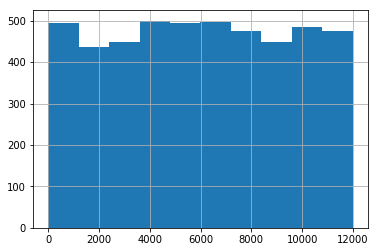

In [13]:
data['Unnamed: 0'].hist()

In [14]:
data.drop(columns='Unnamed: 0',inplace = True) #直接删掉

In [15]:
data.shape

(4754, 87)

In [16]:
len(data['custid'].value_counts())

4754

顾客号，无意义，everyone is different

In [17]:
del(data['custid'])

In [18]:
#交易号 'trade_no'
len(data['trade_no'].value_counts())

4754

交易号，同理无意义，删除

In [19]:
del(data['trade_no'])

In [20]:
# 'id_name'
len(data['id_name'].value_counts())

4309

In [21]:
data['id_name'].head(3)

0     蒋红
1    崔向朝
2    王中云
Name: id_name, dtype: object

客户名字。无意义删掉

In [22]:
del(data['id_name'])

In [23]:
data.shape

(4754, 84)

## 类型转换

In [24]:
overall(data)

we have 70 columns in type float64, they are ['low_volume_percent', 'middle_volume_percent', 'trans_amount_increase_rate_lately', 'trans_activity_month', 'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter', 'trans_days_interval', 'regional_mobility', 'student_feature', 'number_of_trans_from_2011', 'first_transaction_time', 'historical_trans_day', 'rank_trad_1_month', 'avg_consume_less_12_valid_month', 'top_trans_count_last_1_month', 'avg_price_top_last_12_valid_month', 'trans_top_time_last_1_month', 'trans_top_time_last_6_month', 'consume_top_time_last_1_month', 'consume_top_time_last_6_month', 'cross_consume_count_last_1_month', 'trans_fail_top_count_enum_last_1_month', 'trans_fail_top_count_enum_last_6_month', 'trans_fail_top_count_enum_last_12_month', 'consume_mini_time_last_1_month', 'max_consume_count_later_6_month', 'railway_consume_count_last_12_month', 'jewelry_consume_count_last_6_month', 'first_transaction_day', 'trans_day_last_12_month', 'apply_score', 'apply_cr

有三个非数值型数据需要处理，后面两个是时间，统一改成datetime64[ns].之后时间就可以做加减运算了  
后来因为相关性分析的时候需要float类型，所以改成了datetime64[ns]

In [25]:
len(data['reg_preference_for_trad'].value_counts())

5

In [26]:
data['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

In [27]:
data['reg_preference_for_trad'].replace({'一线城市':1,'二线城市'
                                         :2,'三线城市':3,'境外':4,'其他城市':5},inplace = True)

In [28]:
#处理时间
data.loc[:,['loans_latest_time','latest_query_time']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 2 columns):
loans_latest_time    4457 non-null object
latest_query_time    4450 non-null object
dtypes: object(2)
memory usage: 74.4+ KB


In [29]:
data.loc[:,['loans_latest_time','latest_query_time']].head(3)

,loans_latest_time,latest_query_time
0,2018-04-19,2018-04-25
1,2018-05-05,2018-05-03
2,2018-05-01,2018-05-05


In [30]:
data['latest_query_time']=data['latest_query_time'].apply(lambda x:float(str(x)[:4]+str(x)[5:7]+str(x)[8:]))
data['loans_latest_time']=data['loans_latest_time'].apply(lambda x:float(str(x)[:4]+str(x)[5:7]+str(x)[8:]))

In [31]:
data.loc[:,['loans_latest_time','latest_query_time']].head(3)

,loans_latest_time,latest_query_time
0,20180419.0,20180425.0
1,20180505.0,20180503.0
2,20180501.0,20180505.0


## 缺失值处理

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 84 columns):
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
student_feature                               1756 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans

In [33]:
overall(data)

we have 73 columns in type float64, they are ['low_volume_percent', 'middle_volume_percent', 'trans_amount_increase_rate_lately', 'trans_activity_month', 'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter', 'trans_days_interval', 'regional_mobility', 'student_feature', 'number_of_trans_from_2011', 'first_transaction_time', 'historical_trans_day', 'rank_trad_1_month', 'avg_consume_less_12_valid_month', 'top_trans_count_last_1_month', 'avg_price_top_last_12_valid_month', 'reg_preference_for_trad', 'trans_top_time_last_1_month', 'trans_top_time_last_6_month', 'consume_top_time_last_1_month', 'consume_top_time_last_6_month', 'cross_consume_count_last_1_month', 'trans_fail_top_count_enum_last_1_month', 'trans_fail_top_count_enum_last_6_month', 'trans_fail_top_count_enum_last_12_month', 'consume_mini_time_last_1_month', 'max_consume_count_later_6_month', 'railway_consume_count_last_12_month', 'jewelry_consume_count_last_6_month', 'first_transaction_day', 'trans_day_last_12_month

In [34]:
#缺失最明显的特征
data['student_feature'].value_counts(dropna=False)   #参数表示缺失值也要统计

NaN    2998
1.0    1754
2.0       2
Name: student_feature, dtype: int64

In [35]:
2998/4754

0.6306268405553218

缺失率60%多。但是是否有意义，还要看看和标签列的相关性

In [36]:
data['status'].value_counts(dropna=False)

0    3561
1    1193
Name: status, dtype: int64

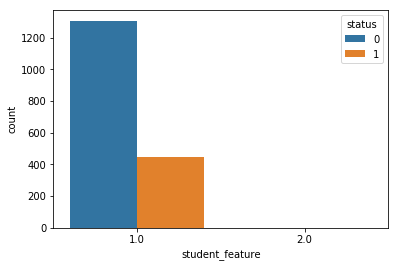

In [37]:
sns.countplot(data = data, x = 'student_feature', hue = 'status')

In [38]:
data[data['student_feature']==2.0]['status']

2989    0
2991    1
Name: status, dtype: int64

看不出有什么有什么相关性，所以drop掉

In [39]:
del(data['student_feature'])

再从行的角度，也就是样本的角度看看NA的分布

In [40]:
data[data.isnull().T.any()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 6 to 4748
Data columns (total 83 columns):
low_volume_percent                            769 non-null float64
middle_volume_percent                         769 non-null float64
take_amount_in_later_12_month_highest         771 non-null int64
trans_amount_increase_rate_lately             768 non-null float64
trans_activity_month                          769 non-null float64
trans_activity_day                            769 non-null float64
transd_mcc                                    769 non-null float64
trans_days_interval_filter                    763 non-null float64
trans_days_interval                           769 non-null float64
regional_mobility                             769 non-null float64
repayment_capability                          771 non-null int64
is_high_user                                  771 non-null int64
number_of_trans_from_2011                     769 non-null float64
first_transaction_time       

In [41]:
1-771/4754

0.8378207824989483

如果把带有NA的行全部drop,还能保留83.78%的数据，姑且认为对模型的影响较小

In [42]:
data.dropna(inplace=True)
data.shape

(3983, 83)

In [43]:
data.T.isnull().any().sum()

0

In [44]:
data.isnull().any().sum()

0

## 离群值处理
- 判断：观察分布 画箱图等
- 危害：影响统计特征比如均值、方差等的计算
- 方法：对数转换/缩尾/截尾/插值

暂时没找到想要尝试的方法，先划分数据集 然后进入特征工程吧

### 数据集划分

In [45]:
features = [x for x in data.columns if x not in ['status']]

In [46]:
from sklearn.model_selection import train_test_split
X = data[features]
y = data.status

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2018)

In [47]:
X_train.shape

(2788, 82)

In [48]:
X_test.shape

(1195, 82)

In [49]:
#features[int_columns].head(3)
X_train.select_dtypes(include=['object']).columns.values

array([], dtype=object)

In [50]:
X_train.loc[:,['loans_latest_time','latest_query_time']].head(3)

,loans_latest_time,latest_query_time
2007,20180412.0,20180414.0
3782,20180418.0,20180425.0
1246,20171228.0,20180406.0


In [51]:
from sklearn.feature_selection import mutual_info_classif as MIC
result_MIC = MIC(X_train,y_train)
sum(result_MIC<=0)

34

## 模型尝试

### 决策树

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 模型评估

> 观察accuracy、precision，recall和f1-score、auc的取值，并画出roc曲线图

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
%matplotlib inline

In [54]:
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # 精准率
    print('[精准率]', end = ' ')
    print('训练集：', '%.4f'%precision_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%precision_score(y_test, y_test_pred))

    # 召回率
    print('[召回率]', end = ' ')
    print('训练集：', '%.4f'%recall_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%recall_score(y_test, y_test_pred))
    
    # f1-score
    print('[f1-score]', end = ' ')
    print('训练集：', '%.4f'%f1_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%f1_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
    # roc曲线
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

[准确率] 训练集： 0.8056 测试集： 0.7356
[精准率] 训练集： 0.6621 测试集： 0.4183
[召回率] 训练集： 0.5280 测试集： 0.3818
[f1-score] 训练集： 0.5875 测试集： 0.3992
[auc值] 训练集： 0.8025 测试集： 0.6986


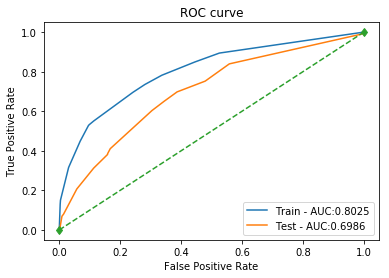

In [55]:
# 决策树，不需要标准化 or 归一化
model_metrics(dt, X_train, X_test, y_train, y_test)

进行特征选择之前的决策树模型，记录一下

## Task2 特征工程
- 计算特征的IV值
- 随机森林筛选特征

### 计算IV值

In [56]:
import math
import numpy as np
from scipy import stats
from sklearn.utils.multiclass import type_of_target

def woe(X, y, event=1):  
    res_woe = []
    iv_dict = {}
    for feature in X.columns:
        x = X[feature].values
        # 1) 连续特征离散化
        if type_of_target(x) == 'continuous':
            x = discrete(x)
        # 2) 计算该特征的woe和iv
        # woe_dict, iv = woe_single_x(x, y, feature, event)
        woe_dict, iv = woe_single_x(x, y, feature, event)
        iv_dict[feature] = iv
        res_woe.append(woe_dict) 
        
    return iv_dict
        
def discrete(x):
    # 使用5等分离散化特征
    res = np.zeros(x.shape)
    for i in range(5):
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        x1 = x[np.where((x >= point1) & (x <= point2))]
        mask = np.in1d(x, x1)
        res[mask] = i + 1    # 将[i, i+1]块内的值标记成i+1
    return res

def woe_single_x(x, y, feature,event = 1):
    # event代表预测正例的标签
    event_total = sum(y == event)
    non_event_total = y.shape[-1] - event_total
    
    iv = 0
    woe_dict = {}
    for x1 in set(x):    # 遍历各个块
        y1 = y.reindex(np.where(x == x1)[0])
        event_count = sum(y1 == event)
        non_event_count = y1.shape[-1] - event_count
        rate_event = event_count / event_total    
        rate_non_event = non_event_count / non_event_total
        
        if rate_event == 0:
            rate_event = 0.0001
            # woei = -20
        elif rate_non_event == 0:
            rate_non_event = 0.0001
            # woei = 20
        woei = math.log(rate_event / rate_non_event)
        woe_dict[x1] = woei
        iv += (rate_event - rate_non_event) * woei
    return woe_dict, iv


为了避免极端情况，即响应数为0。对极端值进行平滑处理

In [57]:
import warnings
warnings.filterwarnings("ignore")  #不打印报警信息

iv_dict = woe(X_train, y_train)

In [58]:
iv = sorted(iv_dict.items(), key = lambda x:x[1],reverse = True)
iv

[('historical_trans_amount', 2.8052032523465145),
 ('trans_amount_3_month', 2.678747615502215),
 ('pawns_auctions_trusts_consume_last_6_month', 2.631743389798647),
 ('repayment_capability', 2.592331503025519),
 ('first_transaction_time', 2.456140861322291),
 ('first_transaction_day', 2.4561408613222566),
 ('abs', 2.3936833285862416),
 ('consfin_avg_limit', 2.031419858853117),
 ('max_cumulative_consume_later_1_month', 1.872184992108639),
 ('loans_avg_limit', 1.7153384768783324),
 ('consume_mini_time_last_1_month', 1.6701805115232629),
 ('historical_trans_day', 1.4363460276516111),
 ('pawns_auctions_trusts_consume_last_1_month', 1.2632076738585964),
 ('consfin_credit_limit', 1.0812666230410581),
 ('loans_score', 1.0244473030795787),
 ('apply_score', 1.0103792064915054),
 ('avg_price_last_12_month', 0.9949957027792705),
 ('loans_latest_day', 0.8908344358264068),
 ('loans_latest_time', 0.8893029185216818),
 ('history_suc_fee', 0.8779005888254906),
 ('loans_count', 0.817176616489504),
 ('co

### 随机森林挑选特征

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

袋外分数： 0.7446197991391679
[准确率] 训练集： 0.9806 测试集： 0.7874
[精准率] 训练集： 0.9985 测试集： 0.5755
[召回率] 训练集： 0.9275 测试集： 0.2909
[f1-score] 训练集： 0.9617 测试集： 0.3865
[auc值] 训练集： 0.9995 测试集： 0.7147


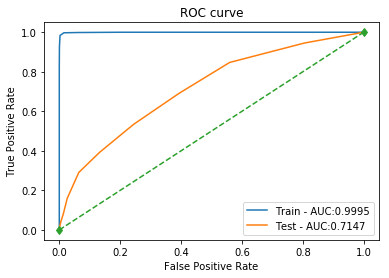

In [60]:
# 观察默认参数的性能
rf0 = RandomForestClassifier(oob_score=True, random_state=2018)
rf0.fit(X_train, y_train)
print('袋外分数：', rf0.oob_score_)
model_metrics(rf0, X_train, X_test, y_train, y_test)

In [61]:
# 网格法调参, 步骤省略...后续补充
param_test = {'n_estimators':range(20,200,20)}
# param_test = {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}
# param_test = {'min_samples_split':range(10,100,20), 'min_samples_leaf':range(10,60,10)}
# param_test = {'max_features':range(3,17,2)}
gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50, 
                                                          min_samples_leaf=20, max_features = 9,random_state=2333), 
                       param_grid = param_test, scoring='roc_auc', cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 120}, 0.8126527801759443)

袋外分数： 0.7887374461979914
[准确率] 训练集： 0.8228 测试集： 0.7975
[精准率] 训练集： 0.8738 测试集： 0.6571
[召回率] 训练集： 0.3789 测试集： 0.2509
[f1-score] 训练集： 0.5286 测试集： 0.3632
[auc值] 训练集： 0.9070 测试集： 0.7545


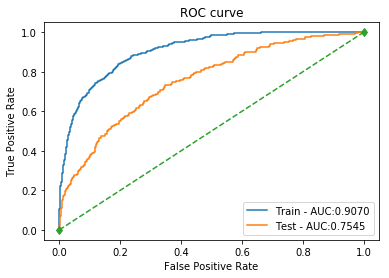

In [62]:
rf = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50,
                            min_samples_leaf=20, max_features = 9,oob_score=True, random_state=2018)
rf.fit(X_train, y_train)
print('袋外分数：', rf.oob_score_)
model_metrics(rf, X_train, X_test, y_train, y_test)

### 平均不纯度减少 mean decrease impurity

> 下面代码是基于Gini指数

In [63]:
rf.fit(X_train, y_train)
feature_impotance1 = sorted(zip(map(lambda x: '%.4f'%x, rf.feature_importances_), list(X_train.columns)), reverse=True)

In [64]:
feature_impotance1[:10]

[('0.1209', 'history_fail_fee'),
 ('0.1160', 'trans_fail_top_count_enum_last_1_month'),
 ('0.0995', 'loans_score'),
 ('0.0569', 'latest_one_month_fail'),
 ('0.0527', 'apply_score'),
 ('0.0502', 'loans_overdue_count'),
 ('0.0278', 'trans_fail_top_count_enum_last_6_month'),
 ('0.0222', 'latest_one_month_suc'),
 ('0.0176', 'trans_fail_top_count_enum_last_12_month'),
 ('0.0165', 'trans_day_last_12_month')]

### 平均精确率减少 Mean decrease accuracy

In [65]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import cross_val_score, ShuffleSplit

scores = defaultdict(list)
rs = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for train_idx, test_idx in rs.split(X_train):
    x_train, x_test = X_train.values[train_idx], X_train.values[test_idx]
    Y_train, Y_test = y_train.values[train_idx], y_train.values[test_idx]
    r = rf.fit(x_train, Y_train)
    acc = accuracy_score(Y_test, rf.predict(x_test))
    for i in range(x_train.shape[1]):
        X_t = x_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = accuracy_score(Y_test, rf.predict(X_t))
        scores[X_train.columns[i]].append((acc - shuff_acc) / acc)
        
feature_impotance2=sorted([('%.4f'%np.mean(score), feat) for feat, score in scores.items()], reverse=True)

In [66]:
feature_impotance2[:10]

[('0.0290', 'history_fail_fee'),
 ('0.0127', 'trans_fail_top_count_enum_last_1_month'),
 ('0.0103', 'loans_score'),
 ('0.0103', 'apply_score'),
 ('0.0045', 'loans_overdue_count'),
 ('0.0045', 'latest_one_month_suc'),
 ('0.0033', 'rank_trad_1_month'),
 ('0.0021', 'latest_query_day'),
 ('0.0018', 'latest_one_month_fail'),
 ('0.0018', 'consume_top_time_last_1_month')]

### 综合挑选特征

In [67]:
feature_impotance1[40], feature_impotance2[20]

(('0.0061', 'loans_long_time'), ('0.0006', 'consfin_avg_limit'))

In [68]:
useless = []
for feature in X_train.columns:
    if feature in [t[1] for t in feature_impotance1[50:]] and feature in [t[1] for t in feature_impotance2[20:]]:
        useless.append(feature)
        print(feature, iv_dict[feature])

low_volume_percent 0.44152144913771435
middle_volume_percent 0.4378044658205401
take_amount_in_later_12_month_highest 0.6872770764961481
trans_activity_month 0.4323857530692425
transd_mcc 0.4930538600820277
regional_mobility 0.4381071481848373
is_high_user 0.4305304326775824
number_of_trans_from_2011 0.585048141234158
avg_consume_less_12_valid_month 0.45321915425691417
avg_price_top_last_12_valid_month 0.4313118203258681
reg_preference_for_trad 0.436133545691512
consume_top_time_last_6_month 0.6085524360439833
cross_consume_count_last_1_month 0.45285304290324263
max_consume_count_later_6_month 0.5038314125322784
railway_consume_count_last_12_month 0.43312485185755056
jewelry_consume_count_last_6_month 0.4403010647754467
apply_credibility 0.505162209289343
query_org_count 0.5704622586972827
query_finance_count 0.4674584338704618
query_cash_count 0.4523433623130917
query_sum_count 0.6663280062574117
latest_three_month_apply 0.5481973327427607
loans_credibility_behavior 0.4780910943319019

In [69]:
len(useless)

31

In [70]:
X_train.drop(useless, axis = 1, inplace = True)
X_test.drop(useless, axis = 1, inplace = True)

袋外分数： 0.7883787661406025
[准确率] 训练集： 0.8307 测试集： 0.7908
[精准率] 训练集： 0.8627 测试集： 0.5954
[召回率] 训练集： 0.4213 测试集： 0.2836
[f1-score] 训练集： 0.5662 测试集： 0.3842
[auc值] 训练集： 0.9046 测试集： 0.7594


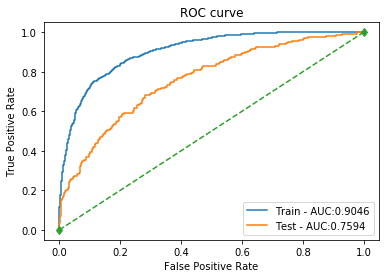

In [71]:
rf = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50,
                            min_samples_leaf=20, max_features = 9,oob_score=True, random_state=2018)
rf.fit(X_train, y_train)
print('袋外分数：', rf.oob_score_)
model_metrics(rf, X_train, X_test, y_train, y_test)

In [72]:
X_train.columns.value_counts()

consfin_avg_limit                             1
latest_one_month_apply                        1
trans_fail_top_count_enum_last_12_month       1
trans_top_time_last_6_month                   1
trans_top_time_last_1_month                   1
history_fail_fee                              1
history_suc_fee                               1
trans_days_interval                           1
trans_amount_3_month                          1
pawns_auctions_trusts_consume_last_1_month    1
loans_latest_day                              1
loans_max_limit                               1
repayment_capability                          1
loans_settle_count                            1
loans_org_count_behavior                      1
trans_fail_top_count_enum_last_6_month        1
loans_long_time                               1
apply_score                                   1
trans_day_last_12_month                       1
consfin_credit_limit                          1
first_transaction_day                   

In [73]:
len(X_train.columns)

51

至此，筛选出了52个特征。

In [74]:
len(X_test.columns)

51

In [75]:
X_train.head(3)

,trans_amount_increase_rate_lately,trans_activity_day,trans_days_interval_filter,trans_days_interval,repayment_capability,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,...,loans_latest_time,loans_credit_limit,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
2007,3.43,0.558,14.0,9.0,7060,20170315.0,582660,201.0,0.1,138740,...,20180412.0,2000.0,6.0,2800.0,1833.0,17700.0,30000.0,11900.0,23.0,25.0
3782,0.96,0.345,28.0,17.0,12310,20151227.0,163550,154.0,1.0,12090,...,20180418.0,1500.0,7.0,1800.0,1400.0,21200.0,49200.0,11412.0,12.0,19.0
1246,0.68,0.202,30.0,27.0,12240,20160229.0,118300,75.0,0.4,25740,...,20171228.0,2900.0,6.0,5000.0,2066.0,20900.0,30600.0,14220.0,31.0,130.0


## Task3正式开始建模
- lr/SVC/DT
- RF/xgb
- 评估

### LR

In [76]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

[准确率] 训练集： 0.8307 测试集： 0.7908
[精准率] 训练集： 0.8627 测试集： 0.5954
[召回率] 训练集： 0.4213 测试集： 0.2836
[f1-score] 训练集： 0.5662 测试集： 0.3842
[auc值] 训练集： 0.9046 测试集： 0.7594


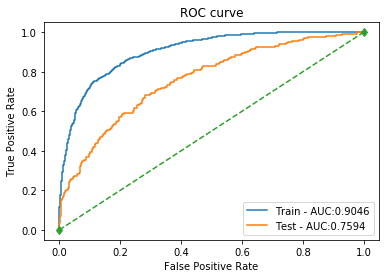

In [77]:
model_metrics(rf, X_train, X_test, y_train, y_test)

### DT

In [78]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

[准确率] 训练集： 0.8049 测试集： 0.7364
[精准率] 训练集： 0.6609 测试集： 0.4200
[召回率] 训练集： 0.5253 测试集： 0.3818
[f1-score] 训练集： 0.5854 测试集： 0.4000
[auc值] 训练集： 0.8011 测试集： 0.7045


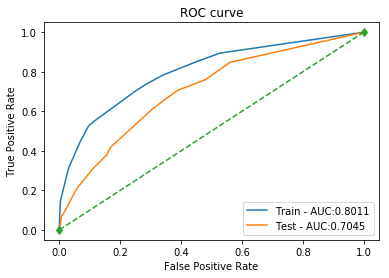

In [79]:
model_metrics(dt,X_train,X_test, y_train, y_test)

### RF

In [80]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50,
                            min_samples_leaf=20, max_features = 9,oob_score=True, random_state=2018)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=True, random_state=2018, verbose=0, warm_start=False)

[准确率] 训练集： 0.8307 测试集： 0.7908
[精准率] 训练集： 0.8627 测试集： 0.5954
[召回率] 训练集： 0.4213 测试集： 0.2836
[f1-score] 训练集： 0.5662 测试集： 0.3842
[auc值] 训练集： 0.9046 测试集： 0.7594


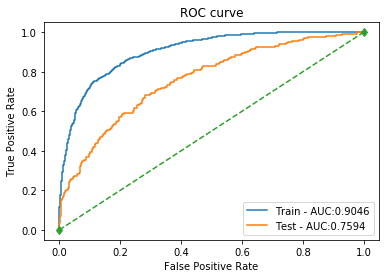

In [81]:
model_metrics(rf, X_train, X_test, y_train, y_test)

### xgb

In [82]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

[准确率] 训练集： 0.8651 测试集： 0.7925
[精准率] 训练集： 0.8675 测试集： 0.5771
[召回率] 训练集： 0.5732 测试集： 0.3673
[f1-score] 训练集： 0.6903 测试集： 0.4489
[auc值] 训练集： 0.9205 测试集： 0.7727


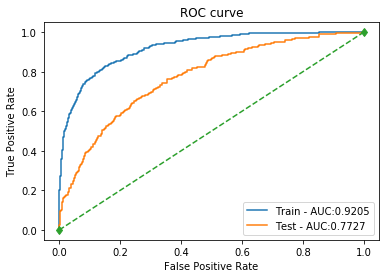

In [83]:
model_metrics(xgb,X_train, X_test, y_train, y_test)

### SVC

In [85]:
from sklearn import svm

In [ ]:
#svm_linear = svm.SVC(kernel = 'linear', probability=True).fit(X_train, y_train)   #运行时间太长,问题就出现在这里

In [93]:
svm_poly = svm.SVC(kernel = 'poly', probability=True).fit(X_train, y_train)
svm_rbf = svm.SVC(probability=True).fit(X_train, y_train)
svm_sigmoid = svm.SVC(kernel = 'sigmoid',probability=True).fit(X_train, y_train)

In [87]:
svm_rbf = svm.SVC(probability=True).fit(X_train, y_train)

In [88]:
svm_sigmoid = svm.SVC(kernel = 'sigmoid',probability=True).fit(X_train, y_train)

[准确率] 训练集： 0.2622 测试集： 0.2301
[精准率] 训练集： 0.2622 测试集： 0.2301
[召回率] 训练集： 1.0000 测试集： 1.0000
[f1-score] 训练集： 0.4155 测试集： 0.3741
[auc值] 训练集： 0.5000 测试集： 0.5000


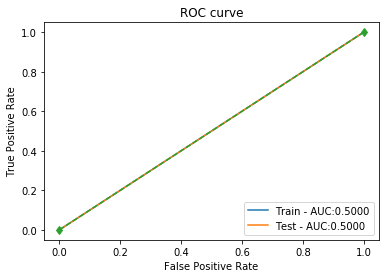

In [94]:
model_metrics(svm_poly,X_train, X_test, y_train, y_test)

[准确率] 训练集： 1.0000 测试集： 0.7699
[精准率] 训练集： 1.0000 测试集： 0.0000
[召回率] 训练集： 1.0000 测试集： 0.0000
[f1-score] 训练集： 1.0000 测试集： 0.0000
[auc值] 训练集： 0.0000 测试集： 0.5000


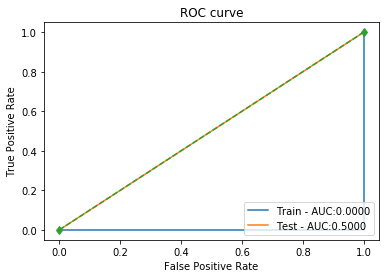

In [95]:
model_metrics(svm_rbf,X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7378 测试集： 0.7699
[精准率] 训练集： 0.0000 测试集： 0.0000
[召回率] 训练集： 0.0000 测试集： 0.0000
[f1-score] 训练集： 0.0000 测试集： 0.0000
[auc值] 训练集： 0.5000 测试集： 0.5000


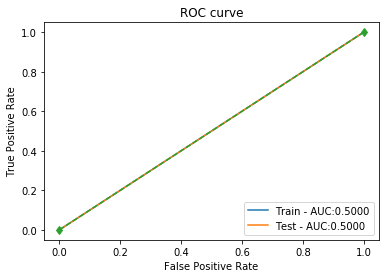

In [96]:
model_metrics(svm_sigmoid,X_train, X_test, y_train, y_test)